## MCMC Review: can anyone say what it is NOT?
(a) a method to estimate the posterior

(b) a method that relies on estimating the marginal likelihood

(c) a method that directly samples from the posterior distribution

(d) a method that needs a likelihood and prior

## Hierarchical Bayes
Bayes about two things for our purposes:

Parameter estimation: here, we want the posterior of parameters given the data, assuming a type of model of e.g., learning. When we do this, the parameters are nested within subjects that are themselves nested within a population.

Model fitting: Sometimes we marginalize over these parameters. This is the case in model comparison, where a bayes factor is a likelihood ratio of p(data|modelRL)p(data|modelWSLS).

We can do these simultaneously in hierarchical bayes modeling. For now, we'll go through our first hierarchical modelling with some of my recent pilot data below.

## Load in choice data

In [19]:
import pandas as pd
import numpy as np
from scipy import stats
choice_data_binomial=np.load('choice_data.npy')

##  Modelling pilot data hierarchically: explaining choice data

In the present experiment, participants chose an action to obtain a reward based off a latent transition matrix they've presumably learned. The hypothesis is that this transition matrix is altered due to experimentally-manipulated features (valence of emotional distractors during learning) and person-specific factors that are not manipulated (level of chronic worry). 

We can conceive of the generative model of my data in the following way as a Bayesian variant of a within-subjects ANOVA. We'll start from the bottom up. Each individual's decision is either a 1 or 0 (did they select the best-available option or not). The best-available option is the action that maximizes the EV according to a greedy policy (which is normative here given that learning has terminated once decision-making begins; that is, if I've learned I have a 60% chance pressing X will get me to the highest reward, and Y will get me there 40% of the time, I should always choose X). 

The $\theta$ parameter determines a subjects' choice. If their bias is 0, it is an index that they're always choosing the worst action. If the bias is 1, they're maximizing performance. 

We use a Bernoulli likelihood to define the **subject-specific** data-generating process to explain their choice data:

$Choice_{i,k,t}$ $\sim$ Bernoulli$(\theta_{i,k})$ Indices: i=subjects, t=trials, k=condition, where k(1) = neutral, k(2) = positive and k(3) = negative. 

These decicision biases, $\theta$, are determied via a joint function of the average effect in the population, $\alpha_0$, a subject-specific factor $\eta_i$, an experimentally-induced effect, $\gamma_k$, and an interaction between the subject factor and experimental factor, $\beta_{i,k}$. A logistic link function is necessary to take a parameter setting spanning all values to the 0 to 1 range in order to be used to jointly define the mean and variance of the Bernoulli likelihood.

$\theta_{i,k}\,= \begin{cases}
    \text{logistic}\, (\alpha_0 + \eta_{i} + \gamma_{1} + \beta_{interaction, i,1}),& \text{if } k=1\\
    \text{logistic}\,(\alpha_0 + \eta_{i} + \gamma_{2} +\beta_{interaction, i,2}),& \text{if } k=2\\
    \text{logistic}\,(\alpha_0 + \eta_{i} + \gamma_{3}+\beta_{interaction, i,3}),& \text{if } k=3\\
\end{cases}
$

$\gamma_{1}$, $\gamma_{2}$, and $\gamma_{3}$ represent the biases for **each condition** modelled as a fixed effect, where each is drawn from **group-level distribution over condition effects**:

$\gamma_{1}$ $\sim \mathcal{N}(0, 10)$

$\gamma_{2}$ $\sim \mathcal{N}(0, 10)$

$\gamma_{3}$ $\sim \mathcal{N}(0, 10)$

$\beta_{interaction,i,k} \sim \mathcal{N}(0, 10)$

We also have a **subject-specific bias** drawn from the population distribution over biases. One can think of this as the tendency to learn well the state transitions in the present task necessary for good performance.

$\eta_i$ $\sim$ $\mathcal{N}(0,10)$

For each parameter, we converted their scale to reflect defletions meeting the sum-to-zero constraint for more interpretability.

The posterior joint distribution one is trying to estimate is: $p(\alpha_0,\eta_i,\gamma_k,\beta_{i,k}|data)$. Thus we must estimate $(\text{Baseline}+i+k+(i\cdot k))$ parameters, which for the present dataset, is a 56-dimensional distribution. Below, I use pyStan to fit the model to the data below.


## Build hierarchical model in pyStan

In [137]:
from pystan import StanModel


model_input='''
data {

    int<lower=1> Ntrials;
    int<lower=1> NxConditions;
    int<lower=1> NxSubjects;
    int Choice[NxSubjects, NxConditions, Ntrials];
}

parameters {   
  // Grand mean
  real a0;
  
  //Conditions
  vector[NxConditions] aW;
  vector[NxSubjects] aS;
  
  // Interaction condition X subject
  matrix[NxConditions,NxSubjects] aWaS; 
    
}

transformed parameters {

vector[NxSubjects] theta_neutral;
vector[NxSubjects] theta_positive;
vector[NxSubjects] theta_negative;

// Translate to sum-to-zero deflections away from Grand Mean 
real b0;
vector[NxConditions] bConditions;
vector[NxSubjects] bSubjects;
matrix[NxConditions,NxSubjects] bSubXCondition;

// Mean predicted values (before logistic transform) per conditionXsubject cell

matrix[NxConditions,NxSubjects] m;

  // Convert parameters to sum-to-zero
  
  for ( u in 1:NxConditions){
      for ( b in 1: NxSubjects){
          m[u,b] = a0+aW[u]+aS[b]+aWaS[u,b];
      }
  }
  // Grand mean (mean over matrix of all cells)
  b0 = mean(m);
  
  //Effects of Condition (how average effect across subjects is different from Grand Mean)
  for (j in 1:NxConditions){bConditions[j]=mean(m[j,1:NxSubjects])-b0;}
  
  //Effects of Subject
  for (h in 1:NxSubjects){bSubjects[h]=mean(m[1:NxConditions,h])-b0;}
  
  // Interaction Effects
  for (j in 1:NxConditions){
      for (k in 1:NxSubjects){
          {bSubXCondition[j,k]=m[j,k]-(b0+bConditions[j]+bSubjects[k]);}
      } 
  }


for (k in 1:NxSubjects){
        theta_neutral[k] = inv_logit(a0+aW[1]+aS[k]+aWaS[1,k]);
        theta_positive[k] = inv_logit(a0+aW[2]+aS[k]+aWaS[2,k]);
        theta_negative[k] = inv_logit(a0+aW[3]+aS[k]+aWaS[3,k]);
        
    }
}
model {
    
    a0 ~ normal(0,10); 
    
    for ( j in 1:NxConditions ) { aW[j] ~ normal(0,10); }
    
    for (k in 1:NxSubjects){
        
        aS[k] ~ normal(0,10);
        
        for (i in 1:Ntrials) {
    
            // Neutral condition choices
            aWaS[1,k] ~ normal(0,10);
            Choice[k,1,i] ~ bernoulli(theta_neutral[k]);

            // Positive condition choices
            aWaS[2,k] ~ normal(0,10);
            Choice[k,2,i] ~ bernoulli(theta_positive[k]);

            // Negative condition choices
            aWaS[3,k] ~ normal(0,10);
            Choice[k,3,i] ~ bernoulli(theta_negative[k]);    
              }
      }
    }
    
'''
data_input = {
              'Ntrials': 40, # trials per condition
              'Choice':choice_data_3d,#choice data
              'NxConditions':3,
              'NxSubjects':13
                    }

# controls={}
# controls['adapt_delta']=0.8

# model_fit = StanModel(model_code=model_input)
# fit = model_fit.sampling(data=data_input,iter=2000)
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5d650453d39a892f725c984672c7e773 NOW.


Inference for Stan model: anon_model_5d650453d39a892f725c984672c7e773.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a0                     3.15    0.15   5.53   -7.7  -0.62   3.27   6.99  13.64   1386    1.0
aW[1]                  2.32    0.13   5.18  -7.55  -1.18   2.24   5.88  12.67   1505    1.0
aW[2]                 -0.03    0.13   5.15  -9.95  -3.58  -0.09   3.48  10.16   1562    1.0
aW[3]                  -0.3    0.13   5.15 -10.31  -3.77  -0.37   3.29  10.01   1528    1.0
aS[1]                 -4.16    0.13   3.04 -10.04  -6.26  -4.16  -2.09   1.73    510   1.01
aS[2]                  9.62    0.14   6.09   -0.2   5.25   8.89  13.35  23.12   1984    1.0
aS[3]                 -6.26    0.13   3.04 -12.03  -8.39  -6.24  -4.22  -0.29    523   1.01
aS[4]                 -0.25    0.13   3.13  -6.29  -2.34  -0.28   1.86   5.

## Plot relevant posterior distributions

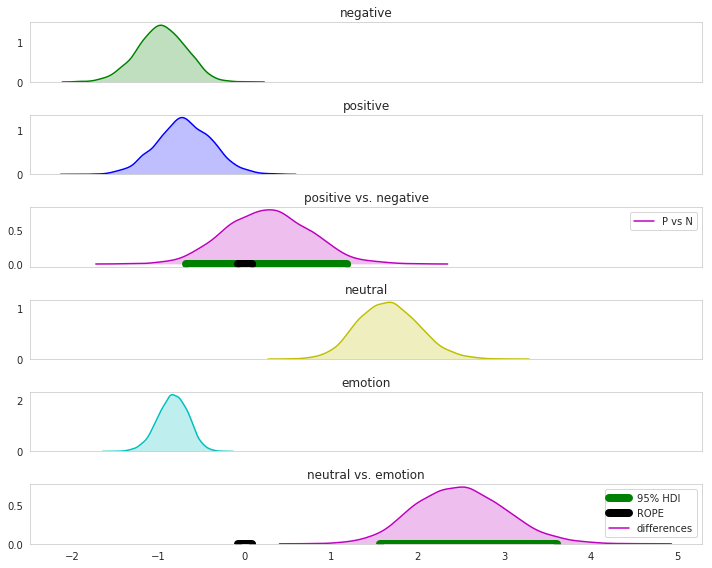

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from bayesian_bootstrap.bootstrap import mean, highest_density_interval
import pandas as pd

# fit_df = fit.to_dataframe()
# fit_df.to_csv('Bayesian_rmANOVA_output.csv')
fit_df=pd.read_csv('Bayesian_rmANOVA_output.csv')
fit_df.keys()

chain_idx = fit_df['draw']
neutral = fit_df['bConditions[1]']
positive = fit_df['bConditions[2]']
negative = fit_df['bConditions[3]']
diff_valence=positive-negative
emotion=((positive+negative)/2.0)
diff=neutral-((positive+negative)/2.0)
lv, rv = highest_density_interval(diff_valence)
l, r = highest_density_interval(diff)

sns.set_style("whitegrid",{'axes.grid' : False})
f, axs = plt.subplots(6, 1, figsize=(10, 8),sharex=True)

ax1=sns.distplot(negative, hist=False,kde_kws={"shade": True},color="g", ax=axs[0])
ax1.set(title='negative',xlabel='')

ax2=sns.distplot(positive, hist=False, kde_kws={"shade": True},color="b", ax=axs[1])
ax2.set(title='positive',xlabel='')



axv=sns.distplot(diff_valence, hist=False, kde_kws={"shade": True},color="m", ax=axs[2],label='P vs N')
axv.set(title='positive vs. negative',xlabel='')
axs[2].plot([lv, rv],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='g')
axs[2].plot([-.081, .081],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')


axn=sns.distplot(neutral, hist=False, kde_kws={"shade": True},color="y", ax=axs[3])
axn.set(title='neutral',xlabel='')

axe=sns.distplot(emotion, hist=False,kde_kws={"shade": True},color="c", ax=axs[4])
axe.set(title='emotion',xlabel='')

axs[5].plot([l, r],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='g')
axs[5].plot([-.081, .081],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax3=sns.distplot(diff, hist=False, kde_kws={"shade": True},color="m", ax=axs[5],label='differences')
ax3.set(title='neutral vs. emotion',xlabel='')


plt.tight_layout()
plt.show()


## Hypothesis testing via Region of Practical Equivalence (ROPE)

The rope defines a range of potential values that insignificantly differ from a "null hypothesis". These are created for the purposes of making decisions based on the posterior distributions generated by bayesian model fitting. 

Here we define the ROPE via a heuristic used by Kruschke and others, in which we take a the SD of a given effect, multiply it by 0.1 (half of a small effect-size according to Cohen's D definition of effect-size), and add that to null value on either side. Here, the SD we use is that of the posterior distribution of the Grand Mean, which should be thought of as the propensity in the population to learn the latent transition matrix marginalized over subjects differences and types of distraction manipulated in this study. The SD here is 0.81, yielding a ROPE of 0 +/- 0.081. 

### Effect of valence within emotional distractors
The HDI of the posterior distribution over the difference between the negative and positive stimuli being paired with the common transitions is much larger than the ROPE. Kruschke (2018; see https://journals.sagepub.com/doi/pdf/10.1177/2515245918771304) would call this "Undecided" given that many plausible parameter values occur outside the ROPE.

### Effect of emotional vs. neutral distractors
Very clearly, the HDI for the difference between emotional and neutral distractors falls outside the ROPE. In this case, we can decisively reject the null hypothesis defined by the ROPE.